In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,AsinhNorm
%matplotlib inline
import galsim
from scipy.optimize import minimize,least_squares

## These are some simple functions to help with measuring the brightness of faint sources.



In [87]:
def aperturePhotom(image,center=None,radius=None):
    '''
    Sum up the flux inside a circular aperture.
    '''
    
    if radius is None:
        return np.sum(image)
    nx,ny = image.shape
    if center is None:
        center = [(nx-1)/2., (ny-1)/2.]
    xcoords,ycoords = np.arange(nx)-center[0],np.arange(ny)-center[1]
    xx,yy = np.meshgrid(xcoords,ycoords)
    r = np.sqrt(xx**2+yy**2)
    aperture = r<radius
    flux = np.sum(image[aperture])
    return flux

def maxLikePhotom(image,template):
    '''
    Define a maximum likelihood estimator that makes use
    of knowledge of the PSF.
    '''
    # Ensure that the template is normalized.
    template = template / np.sum(template)
    flux = np.sum(image*template) / np.sum(template*template)
    return flux

def gaussianModel(parameters,image=None):
    x0,y0 = parameters[0],parameters[1]
    sigma = parameters[2]
    flux = parameters[3]
    nx,ny = image.shape
    xcoords,ycoords = np.arange(nx),np.arange(ny)
    xmesh,ymesh = np.meshgrid(xcoords,ycoords)
    r = np.sqrt((xmesh-x0)**2 + (ymesh-y0)**2)
    model_normalized =  1./ np.sqrt(2*np.pi*sigma**2) * np.exp(-(r/sigma)**2/2.)
    model_normalized = model_normalized / np.sum(model_normalized)
    model = flux * model_normalized
    return model

def make_galaxy(flux=1, n=1, scale_radius = 4.,add_noise = False, nx=64,ny=64, offset = [0,0]):
    galaxy = galsim.Sersic(n=n,scale_radius=scale_radius,flux=flux)
    psfObj = galsim.Gaussian(sigma=1.)
    galConv = galsim.Convolve([psfObject,sersicObject])
    simImage = galConv.drawImage(scale=1.,offset=offset,nx=nx,ny=ny)
    if add_noise:
        noise = galsim.GaussianNoise(sigma=0.001)
        noise.applyTo(simImage)
    return simImage.array

def make_galaxies(fluxes=[1,1],n=[1,1.5],scale_radii=[4.,3.],nx=64,ny=64,offsets=[[0,0],[5,-3]],add_noise=False):
    simImage = np.zeros((nx,ny))
    for i in range(len(fluxes)):
        print(f"adding flux: {fluxes[i]}")
        simImage = simImage + make_galaxy(flux=fluxes[i],n=n[i],nx=nx,ny=ny,scale_radius = scale_radii[i],offset = offsets[i])
    return simImage

def chisq(parameters, image, psf = None):
    # Get the model prediction.
    model  = make_galaxy(flux=parameters)#galsimModel(parameters,image=image,psf=psf)
    chisq =  np.sum((model - image)**2)
    return chisq

def modelResiduals(parameters,image,psf = None):
    # Get the model prediction.
    model  = galsimModel(parameters,image=image,psf=psf)
    return  (model - image).flatten()



def modelPhotom(image, parameters, residualsFunction,psf=None):
    '''
    Fit a parameterized model to the provided image.
    '''
    result = least_squares(residualsFunction, parameters, method='lm', args=(image,psf))#,options={'xtol':1e-12})
    return result.x


## GalSim is an extremely powerful library for handling modeling of survey images.

As a simple demonstration, here's a block of code that will produce a noisy, psf-convolved galaxy image similar to that at the end of the previous notebook.

This one, however, will be _much_ more accurate, as it automatically optimizes the convolution parameters to produce an accurate result.

The examples here will draw heavily on GalSim, a largely Pythonic toolkit for simulating extraGalactic survey fields, designed with an emphasis on weak lensing.

This makes many of the operations from the previous notebook far easier.

https://galsim-developers.github.io/GalSim


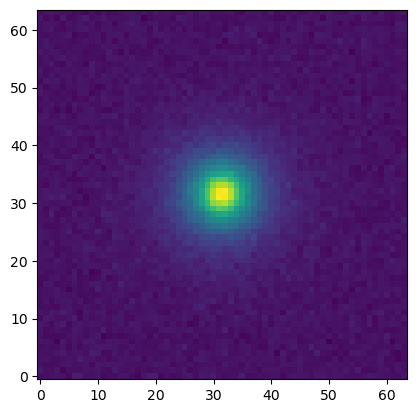

In [36]:
sersicObject = galsim.Sersic(n=1,scale_radius=4.,flux=1.)
psfObject = galsim.Gaussian(sigma=1.)
psfConvObject = galsim.Convolve([psfObject,sersicObject])

image = psfConvObject.drawImage(scale=1.)

noise = galsim.GaussianNoise(sigma=0.0001)
noise.applyTo(image)

plt.imshow(image.array,origin='lower')
plt.show()

1.0024419
0.99625695
0.9994545498670868


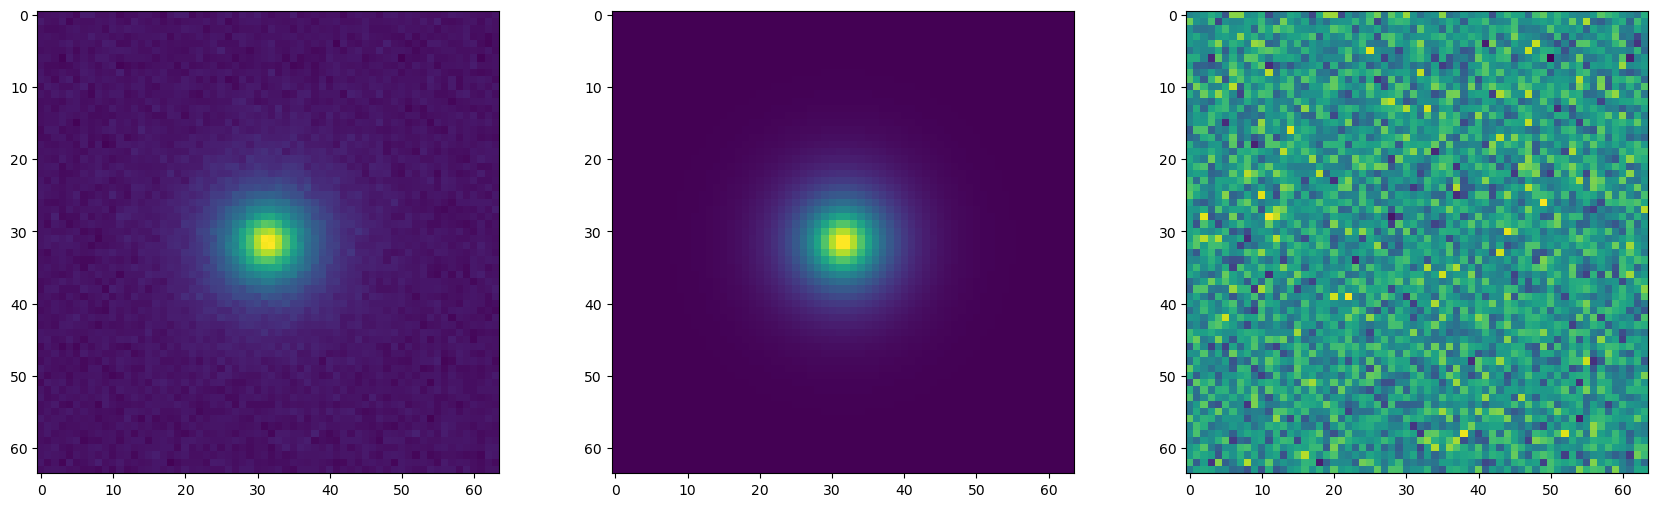

In [41]:
# Try out the photometry.


# First, estimate the aperture photometry
apertureEst = aperturePhotom(image.array)
print(apertureEst)

# Then, create a model template and use that to estimate the max-like flux.
template = psfConvObject.drawImage(scale=1.,nx=image.ncol,ny=image.nrow)
maxLikeEst = maxLikePhotom(image.array,template.array)
print(maxLikeEst)

# Finally, fit a parameterized model.
starting_parameters = np.array([1.1])
modelParams = modelPhotom(image.array,starting_parameters,residuals,psf = psfObject)
modelEst = modelParams[-1]
print(modelEst)


model_galaxy = make_galaxy(modelEst)
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,6))
ax1.imshow(image.array)
ax2.imshow(model_galaxy)
ax3.imshow(image.array - model_galaxy)
plt.show()

## Now let's compare the performance of these estimators. Write a function to make new noise realizations of the image, and measure the distribution of the results.

During the first session today, you spent some time learning how to estimate the flux of an isolated star. You compared the performance of aperture photometry to model-fitting. 

Here, you'll start with a similar task, but add a small amount of realistic complexity.

In [56]:
n_realizations = 1000
apertureEst_array = np.zeros(n_realizations)
maxLikeEst_array = np.zeros(n_realizations)
modelEst_array = np.zeros(n_realizations)



MLtemplate = make_galaxy(flux=1, n=1, scale_radius = 4.,add_noise = False)

for i in range(n_realizations):
    this_image = make_galaxy(add_noise=True)
    apertureEst_array[i] = aperturePhotom(this_image,radius=20)
    maxLikeEst_array[i] = maxLikePhotom(this_image,MLtemplate)
    init_pars = 2*np.random.rand()
    modelParams = modelPhotom(image.array,init_pars,modelResiduals,psf = psfObject)
    modelEst_array[i] = modelParams
    

In [57]:
print("Bias and variance:")
print(f"Aperture photometry -- bias: {np.mean(apertureEst_array)-1:.02}, scatter: {np.std(apertureEst_array)/np.sqrt(n_realizations):.04}")
print(f"Max Like photometry -- bias: {np.mean(maxLikeEst_array)-1:.02}, scatter: {np.std(maxLikeEst_array)/np.sqrt(n_realizations):.04}")
print(f"Model fit photometry -- bias: {np.mean(modelEst_array)-1:.02}, scatter: {np.std(modelEst_array)/np.sqrt(n_realizations):.04}")

Bias and variance:
Aperture photometry -- bias: -0.0051, scatter: 0.00206
Max Like photometry -- bias: -0.0019, scatter: 0.000625
Model fit photometry -- bias: -0.054, scatter: 0.007


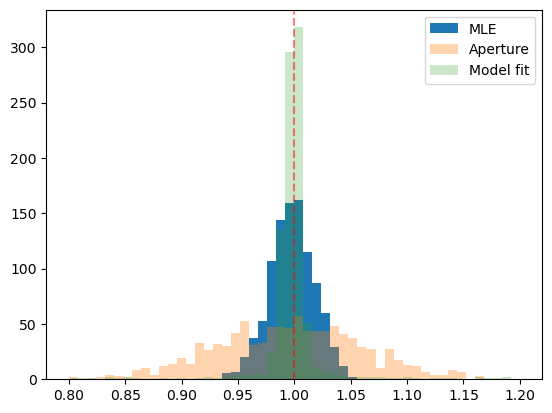

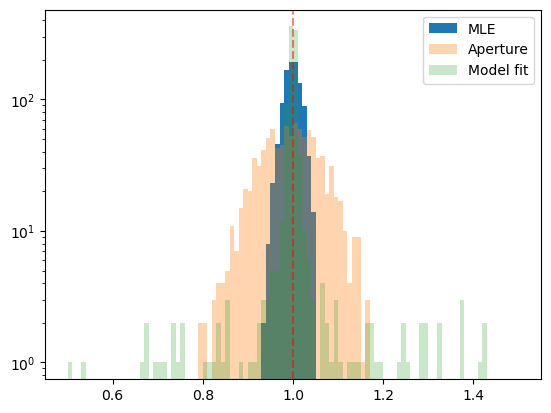

In [70]:
bins = np.linspace(0.8,1.2,51)
plt.hist(maxLikeEst_array,bins=bins,label='MLE')
plt.hist(apertureEst_array,bins=bins,alpha=0.33,label='Aperture')
plt.hist(modelEst_array,bins=bins,alpha=0.25,label='Model fit')
plt.axvline(1,color='red',alpha=0.5,linestyle='--')
plt.legend()
plt.show()

wide_bins = np.linspace(0.5,1.5,101)
plt.hist(maxLikeEst_array,bins=wide_bins,label='MLE',log=True)
plt.hist(apertureEst_array,bins=wide_bins,alpha=0.33,label='Aperture',log=True)
plt.hist(modelEst_array,bins=wide_bins,alpha=0.25,label='Model fit',log=True)
plt.axvline(1,color='red',alpha=0.5,linestyle='--')
plt.legend()
plt.show()

